## Team Members:
## Mariz Youssef Abdelmessih Gerges,  ID: 2001122
## Carol Maged Victor Amin,  ID: 2001072
## Jasmine Mamdouh Mostafa Ibrahim, ID: 2000016


In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score, roc_curve,accuracy_score,precision_score,recall_score
,make_scorer,f1_score,auc,precision_recall_curve)
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
import pydotplus


## Data Visualization

In [4]:
# Load dataset
data = pd.read_csv('data.csv')
# Display the first few rows of the dataset
print(data.columns)

Index(['Unnamed: 0', 'location', 'country', 'gender', 'age', 'vis_wuhan',
       'from_wuhan', 'symptom1', 'symptom2', 'symptom3', 'symptom4',
       'symptom5', 'symptom6', 'diff_sym_hos', 'result'],
      dtype='object')


In [5]:
data.isna().sum()

,0
Unnamed: 0,0
location,0
country,0
gender,0
age,0
vis_wuhan,0
from_wuhan,0
symptom1,0
symptom2,0
symptom3,0


array([[<Axes: title={'center': 'age'}>]], dtype=object)

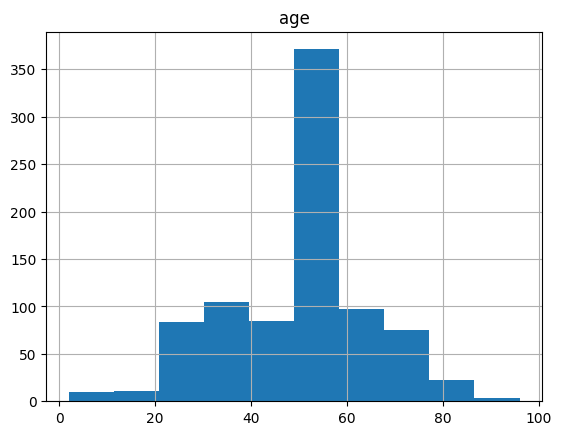

In [6]:
#Checking the range of age of the people we have in the dataset
data.hist(column='age')

<ipython-input-7-e0566d7b8704>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='result', data=data, palette='viridis')


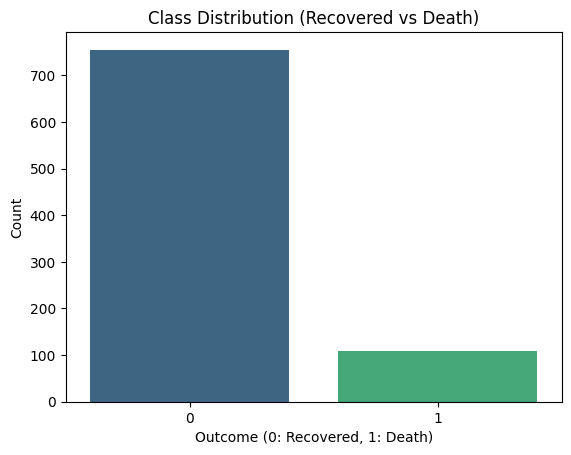

In [7]:
# Check the data balance
data['result'].value_counts()
sns.countplot(x='result', data=data, palette='viridis')
plt.title('Class Distribution (Recovered vs Death)')
plt.xlabel('Outcome (0: Recovered, 1: Death)')
plt.ylabel('Count')
plt.show()

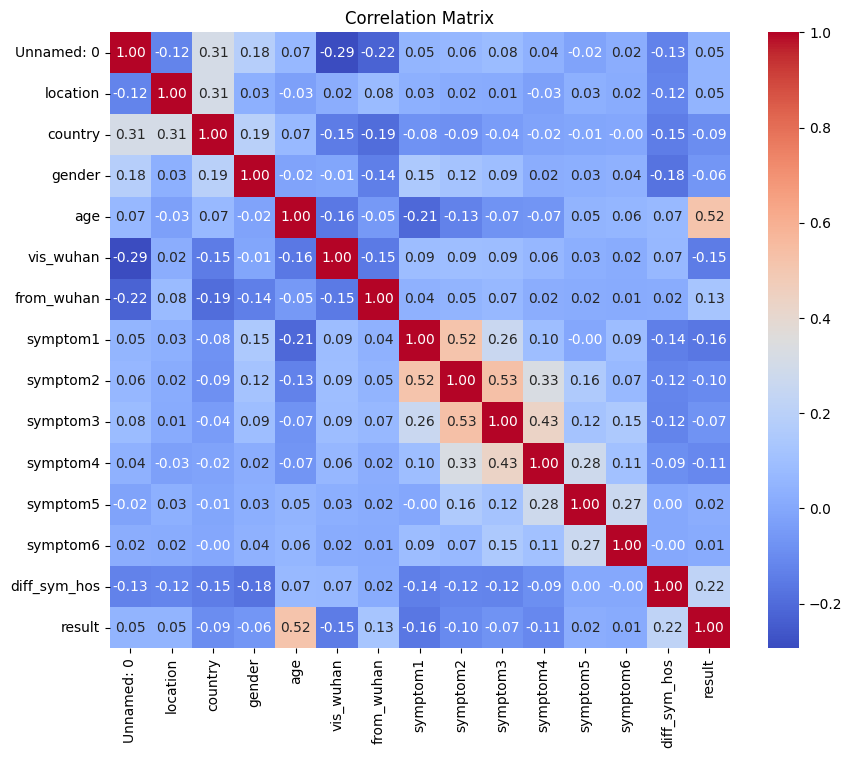

Correlation with target (result):
result          1.000000
age             0.515127
diff_sym_hos    0.219116
from_wuhan      0.128314
Unnamed: 0      0.046838
location        0.046240
symptom5        0.020676
symptom6        0.012882
gender         -0.061441
symptom3       -0.074982
country        -0.094443
symptom2       -0.103270
symptom4       -0.108723
vis_wuhan      -0.151122
symptom1       -0.163039
Name: result, dtype: float64


In [8]:
# Compute the correlation matrix
correlation_matrix = data.corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Get the correlation of each feature with the target ('Result')
target_correlation = correlation_matrix['result'].sort_values(ascending=False)

# Print the correlation of features with the target
print("Correlation with target (result):")
print(target_correlation)


In [9]:
# Based on the correlation matrix results
# Feature-target split, drop useless features (have low values of correlation)
X = data.drop(['result', 'Unnamed: 0','location','symptom5','symptom6'], axis=1)
y = data['result']

# Split into training (70%), validation (15%), and testing (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


# Total number of samples
total_samples = len(data)

# Calculate sizes and percentages
train_size = len(X_train) / total_samples * 100
val_size = len(X_val) / total_samples * 100
test_size = len(X_test) / total_samples * 100

# Print the data sizes and percentages
print(f"Training set size: {len(X_train)} samples ({train_size:.2f}%)")
print(f"Validation set size: {len(X_val)} samples ({val_size:.2f}%)")
print(f"Testing set size: {len(X_test)} samples ({test_size:.2f}%)")


# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)



Training set size: 604 samples (69.99%)
Validation set size: 129 samples (14.95%)
Testing set size: 130 samples (15.06%)


In [10]:
# Justification for Using SMOTE
# 1-Avoids Bias Towards the Majority Class
# 2-Improved Evaluation Metrics
# 3-Balanced Dataset for Better Generalization
RANDOM_STATE=42
smote = SMOTE(random_state=RANDOM_STATE)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


## K-Nearest Neighbors

In [11]:
best_k = 0
best_recall = 0

# Create StratifiedKFold with random_state for consistency
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create a custom scorer using recall
recall_scorer = make_scorer(recall_score)

for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    # Use the recall scorer for cross-validation
    cv_scores = cross_val_score(knn, X_train_resampled, y_train_resampled, cv=5, scoring=recall_scorer)  # 5-fold cross-validation
    mean_recall = cv_scores.mean()
    #print(f"k={k}, Cross-Validation Recall: {mean_recall}")
    if (mean_recall > best_recall) & (k!=1): #to avoid overfitting
        best_k = k
        best_recall = mean_recall

print(f"Optimal number of neighbors (k) for maximum recall: {best_k}")



Optimal number of neighbors (k) for maximum recall: 5


In [12]:
# 5. Train the KNN classifier with the optimal k
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_resampled, y_train_resampled)

KNeighborsClassifier()

In [13]:
# 6. Predict on the test set
y_pred_val = knn.predict(X_val)
y_pred_proba_val = knn.predict_proba(X_val)[:, 1]  # Probability for the positive class
# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_val))

# Classification Report (precision, recall, F1-score)
print("\nClassification Report:")
print(classification_report(y_val, y_pred_val))

# ROC-AUC Score
roc_auc = roc_auc_score(y_val, y_pred_proba_val)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
#fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba_val)
#plt.figure()
#plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
#plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic (ROC)')
#plt.legend(loc="lower right")
#plt.show()

Confusion Matrix:
[[106   7]
 [  0  16]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       113
           1       0.70      1.00      0.82        16

    accuracy                           0.95       129
   macro avg       0.85      0.97      0.89       129
weighted avg       0.96      0.95      0.95       129


ROC-AUC Score: 0.9801


In [14]:
# 6. Predict on the test set
y_pred_knn = knn.predict(X_test)
y_pred_proba_knn = knn.predict_proba(X_test)[:, 1]  # Probability for the positive class

Confusion Matrix:
[[101  13]
 [  2  14]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.89      0.93       114
           1       0.52      0.88      0.65        16

    accuracy                           0.88       130
   macro avg       0.75      0.88      0.79       130
weighted avg       0.92      0.88      0.90       130


ROC-AUC Score: 0.9801


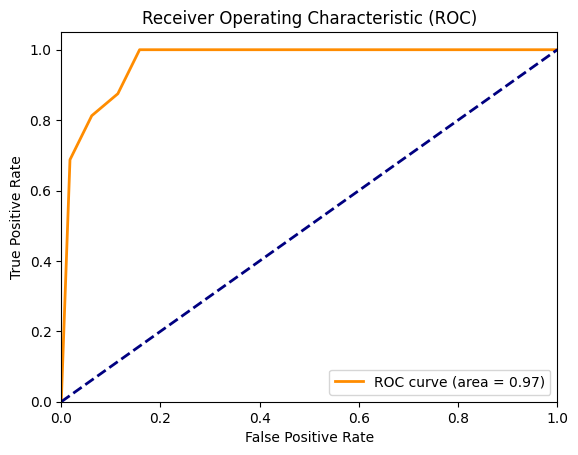

In [15]:
# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))

# Classification Report (precision, recall, F1-score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn))

# ROC-AUC Score
roc_auc_knn = roc_auc_score(y_test, y_pred_proba_knn)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
fpr_knn, tpr_knn, thresholds = roc_curve(y_test, y_pred_proba_knn)
plt.figure()
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_knn:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## Logistic Regression

In [16]:
# Initialize Logistic Regression model
log_reg = LogisticRegression(random_state=RANDOM_STATE)

In [17]:
# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'max_iter': [1000, 5000],
    'class_weight': ['balanced', None],
}

# Perform GridSearchCV with StratifiedKFold
grid_search = GridSearchCV(
    log_reg,
    param_grid,
    scoring='f1',  # Optimize for F1-score
    refit='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    verbose=1
)

# Fit GridSearchCV to the resampled training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Extract the best model
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'C': 1, 'class_weight': 'balanced', 'max_iter': 1000}


In [18]:
# best parameters after experiment
model = LogisticRegression(C=1, max_iter=1000, random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)



LogisticRegression(C=1, max_iter=1000, random_state=42)

In [19]:
# Evaluate on validation data
y_val_proba = model.predict_proba(X_val)[:, 1]  # Probabilities for ROC and threshold tuning

# Tune Threshold for Optimal Precision-Recall Balance
precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_proba)
optimal_idx = np.argmax(2 * (precisions * recalls) / (precisions + recalls))  # Maximize F1-Score
optimal_threshold = thresholds[optimal_idx]

# Apply the new threshold
y_val_pred_threshold = (y_val_proba >= optimal_threshold).astype(int)


In [20]:
# Metrics
print("\nValidation Set Metrics:")
print("Classification Report:")
print(classification_report(y_val, y_val_pred_threshold))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_threshold))

roc_auc = roc_auc_score(y_val, y_val_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

print(f"Optimal Threshold: {optimal_threshold:.4f}")

# Plot ROC Curve
#plt.figure()
#plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
#plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic (ROC)')
#plt.legend(loc="lower right")
#plt.show()


Validation Set Metrics:
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       113
           1       0.76      0.81      0.79        16

    accuracy                           0.95       129
   macro avg       0.87      0.89      0.88       129
weighted avg       0.95      0.95      0.95       129

Confusion Matrix:
[[109   4]
 [  3  13]]
ROC-AUC Score: 0.9707
Optimal Threshold: 0.3799



Test Set Metrics:
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       114
           1       0.78      0.88      0.82        16

    accuracy                           0.95       130
   macro avg       0.88      0.92      0.90       130
weighted avg       0.96      0.95      0.95       130

Confusion Matrix:
[[110   4]
 [  2  14]]
ROC-AUC Score: 0.9545
Optimal Threshold: 0.6224


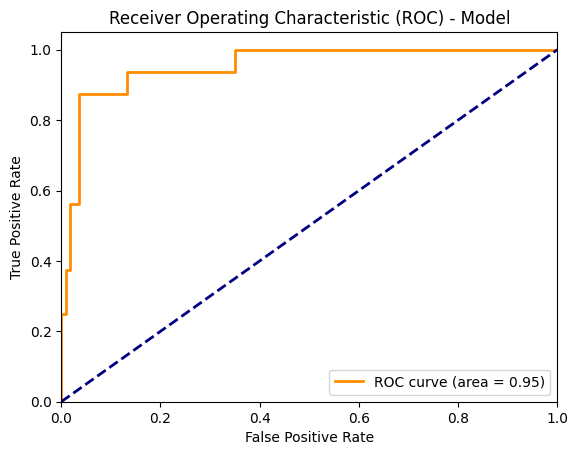

In [21]:
# Evaluate on test data
y_test_proba_logistic = best_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC and threshold tuning

# Tune Threshold for Optimal Precision-Recall Balance
precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_proba_logistic)
optimal_idx = np.argmax(2 * (precisions * recalls) / (precisions + recalls))  # Maximize F1-Score
optimal_threshold = thresholds[optimal_idx]

# Apply the new threshold
y_test_pred_threshold = (y_test_proba_logistic >= optimal_threshold).astype(int)

# Metrics for Test Set
print("\nTest Set Metrics:")
print("Classification Report:")
print(classification_report(y_test, y_test_pred_threshold))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_threshold))

roc_auc_test_logistic = roc_auc_score(y_test, y_test_proba_logistic)
print(f"ROC-AUC Score: {roc_auc_test_logistic:.4f}")

print(f"Optimal Threshold: {optimal_threshold:.4f}")

# Plot ROC Curve
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_test_proba_logistic)
plt.figure()
plt.plot(fpr_logistic, tpr_logistic, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_test_logistic:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Model')
plt.legend(loc="lower right")
plt.show()


## Naive Bayes

In [22]:
RANDOM_STATE=42
# Naïve Bayes with isotonic calibration
naive_bayes=GaussianNB(var_smoothing=1e-9)

# Fit model
naive_bayes.fit(X_train_resampled, y_train_resampled)

# Predict probabilities
y_test_proba_nb = naive_bayes.predict_proba(X_test)[:, 1]


# Predict probabilities
y_val_proba = naive_bayes.predict_proba(X_val)[:, 1]

# Optimize threshold for F1-Score
precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
optimal_idx = np.argmax(f1_scores)
optimal_threshold_nb = thresholds[optimal_idx]

# Apply threshold
y_val_pred_threshold_nb = (y_val_proba >= optimal_threshold_nb).astype(int)

# Metrics
print("\nNaïve Bayes - Vlidation  Metrics:")
print("Classification Report:")
print(classification_report(y_val, y_val_pred_threshold_nb))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_threshold_nb))

roc_auc_test_nb = roc_auc_score(y_val, y_val_proba)
print(f"ROC-AUC Score: {roc_auc_test_nb:.4f}")
#print(f"Optimal Threshold: {optimal_threshold_nb:.4f}")

# ROC Curve
fpr_nb_val, tpr_nb_val, _ = roc_curve(y_val, y_val_proba)
#plt.figure()
#plt.plot(fpr_nb_val, tpr_nb_val, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_test_nb:.2f})')
#plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic (ROC) - Naïve Bayes (validation data)')
#plt.legend(loc="lower right")
plt.show()


Naïve Bayes - Vlidation  Metrics:
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       113
           1       0.58      0.69      0.63        16

    accuracy                           0.90       129
   macro avg       0.77      0.81      0.79       129
weighted avg       0.91      0.90      0.90       129

Confusion Matrix:
[[105   8]
 [  5  11]]
ROC-AUC Score: 0.9181



Naïve Bayes - Test Set Metrics:
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       114
           1       0.59      0.62      0.61        16

    accuracy                           0.90       130
   macro avg       0.77      0.78      0.77       130
weighted avg       0.90      0.90      0.90       130

Confusion Matrix:
[[107   7]
 [  6  10]]
ROC-AUC Score: 0.8766
Optimal Threshold: 0.9755


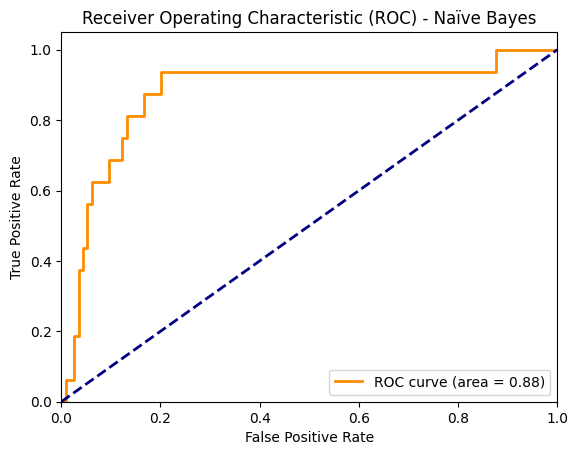

In [23]:
# Optimize threshold for F1-Score
precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_proba_nb)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
optimal_idx = np.argmax(f1_scores)
optimal_threshold_nb = thresholds[optimal_idx]

# Apply threshold
y_test_pred_threshold_nb = (y_test_proba_nb >= optimal_threshold_nb).astype(int)

# Metrics
print("\nNaïve Bayes - Test Set Metrics:")
print("Classification Report:")
print(classification_report(y_test, y_test_pred_threshold_nb))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_threshold_nb))

roc_auc_test_nb = roc_auc_score(y_test, y_test_proba_nb)
print(f"ROC-AUC Score: {roc_auc_test_nb:.4f}")
print(f"Optimal Threshold: {optimal_threshold_nb:.4f}")

# ROC Curve
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_test_proba_nb)
plt.figure()
plt.plot(fpr_nb, tpr_nb, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_test_nb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Naïve Bayes')
plt.legend(loc="lower right")
plt.show()


Decision Tree Classifier

In [24]:
# Initialize Decision Tree model
dt_model = DecisionTreeClassifier(random_state=RANDOM_STATE)

In [25]:
# Define hyperparameter grid for Decision Tree
param_grid_dt = {
    'max_depth': [3, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None]
}

# Perform GridSearchCV with StratifiedKFold
grid_search_dt = GridSearchCV(
    dt_model,
    param_grid_dt,
    scoring='f1',  # Optimize for F1-score
    refit='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    verbose=1
)

# Fit GridSearchCV to the resampled training data
grid_search_dt.fit(X_train_resampled, y_train_resampled)

# Extract the best model
best_dt_model = grid_search_dt.best_estimator_
print(f"Best Parameters for Decision Tree: {grid_search_dt.best_params_}")

# Train the Decision Tree on the training data
best_dt_model.fit(X_train, y_train)


Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Parameters for Decision Tree: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}


DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=42)

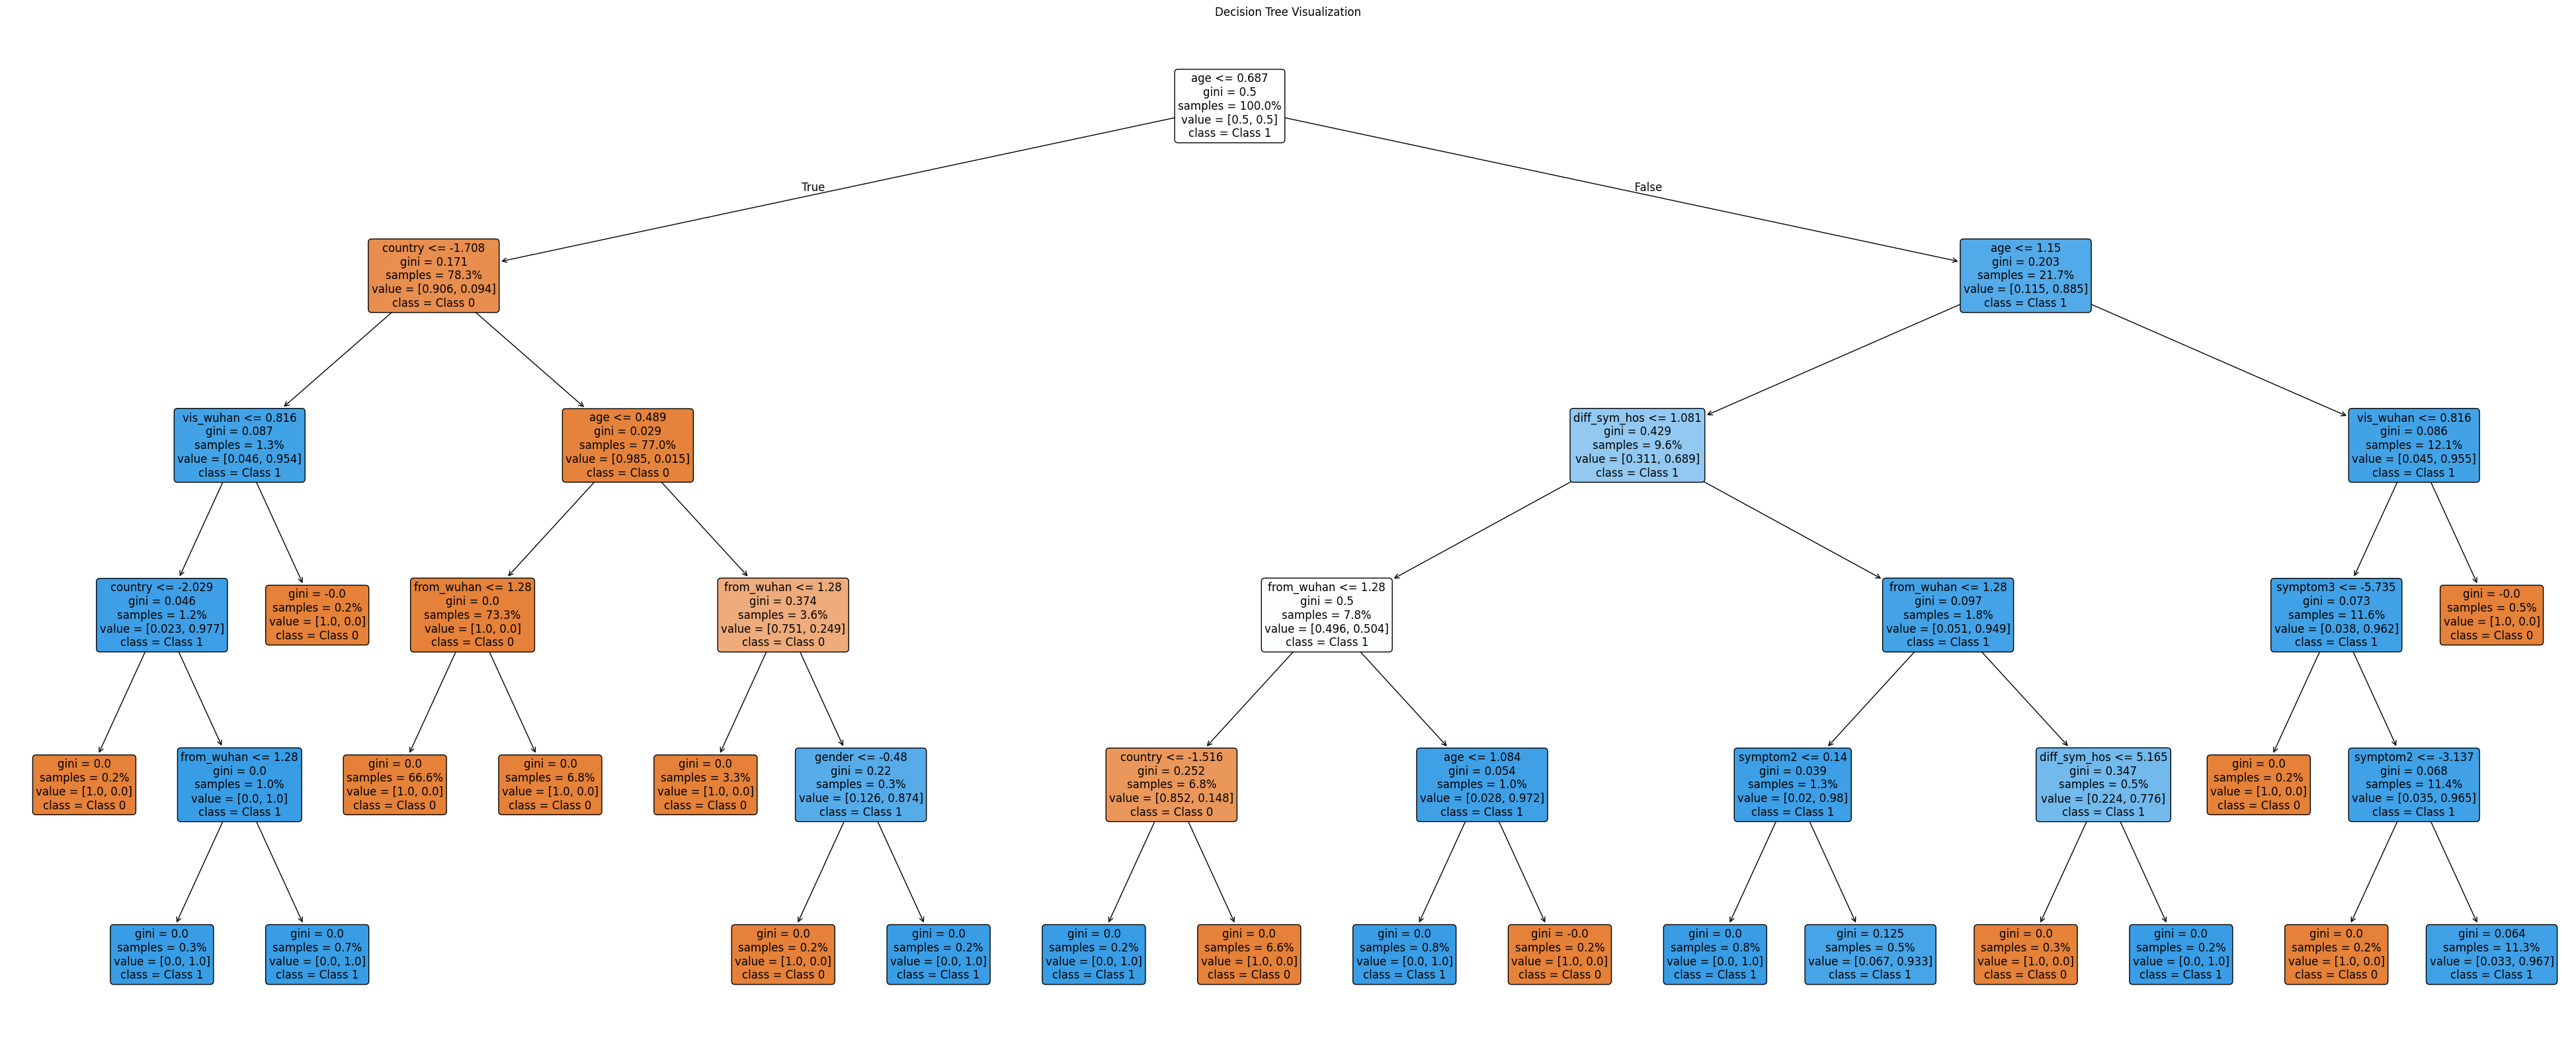

In [39]:
# Visualize the Decision Tree
"""
dot_data = StringIO()
export_graphviz(best_dt_model, out_file = dot_data, rounded = True, filled = True, special_characters = True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png("dtree.png")
Image(graph.create_png())
"""

# Convert X_train to a DataFrame (if it's not already one)
X_train_df = pd.DataFrame(X_train, columns=['country', 'gender', 'age', 'vis_wuhan',
       'from_wuhan', 'symptom1', 'symptom2', 'symptom3', 'symptom4', 'diff_sym_hos',])  # Replace with actual feature names

# Plot the decision tree
plt.figure(figsize=(50, 20))
plot_tree(best_dt_model,
          feature_names=X_train_df.columns,  # Use DataFrame column names
          class_names=['Class 0', 'Class 1'],  # Adjust to your actual class names
          filled=True,  # Color nodes based on class
          rounded=True,  # Round the corners of the nodes
          proportion=True,  # Proportions for the samples
          fontsize=12)  # Font size for text in the tree
plt.title('Decision Tree Visualization')
plt.show()

In [29]:
# Evaluate on validation data
y_val_proba_dt = best_dt_model.predict_proba(X_val)[:, 1]  # Probabilities for ROC and threshold tuning

# Tune Threshold for Optimal Precision-Recall Balance
precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_proba_dt)
optimal_idx = np.argmax(2 * (precisions * recalls) / (precisions + recalls))  # Maximize F1-Score
optimal_threshold_dt = thresholds[optimal_idx]

# Apply the new threshold
y_val_pred_threshold_dt = (y_val_proba_dt >= optimal_threshold_dt).astype(int)

# Metrics
print("\nDecision Tree - Validation Set Metrics:")
print("Classification Report:")
print(classification_report(y_val, y_val_pred_threshold_dt))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_threshold_dt))

roc_auc_dt = roc_auc_score(y_val, y_val_proba_dt)
print(f"ROC-AUC Score: {roc_auc_dt:.4f}")

print(f"Optimal Threshold: {optimal_threshold_dt:.4f}")



Decision Tree - Validation Set Metrics:
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       113
           1       0.79      0.94      0.86        16

    accuracy                           0.96       129
   macro avg       0.89      0.95      0.92       129
weighted avg       0.97      0.96      0.96       129

Confusion Matrix:
[[109   4]
 [  1  15]]
ROC-AUC Score: 0.9450
Optimal Threshold: 0.9329



Decision Tree - Test Set Metrics:
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       114
           1       0.72      0.81      0.76        16

    accuracy                           0.94       130
   macro avg       0.85      0.88      0.86       130
weighted avg       0.94      0.94      0.94       130

Confusion Matrix:
[[109   5]
 [  3  13]]
ROC-AUC Score: 0.8797
Optimal Threshold: 0.9671


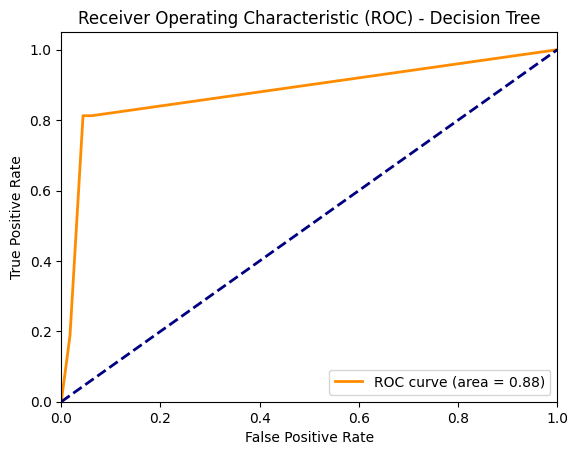

In [30]:
# Evaluate on test data
y_test_proba_dt = best_dt_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC and threshold tuning

# Tune Threshold for Optimal Precision-Recall Balance
precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_proba_dt)
optimal_idx = np.argmax(2 * (precisions * recalls) / (precisions + recalls))  # Maximize F1-Score
optimal_threshold_dt = thresholds[optimal_idx]

# Apply the new threshold
y_test_pred_threshold_dt = (y_test_proba_dt >= optimal_threshold_dt).astype(int)

# Metrics for Test Set
print("\nDecision Tree - Test Set Metrics:")
print("Classification Report:")
print(classification_report(y_test, y_test_pred_threshold_dt))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_threshold_dt))

roc_auc_test_dt = roc_auc_score(y_test, y_test_proba_dt)
print(f"ROC-AUC Score: {roc_auc_test_dt:.4f}")

print(f"Optimal Threshold: {optimal_threshold_dt:.4f}")

# Plot ROC Curve for Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_test_proba_dt)
plt.figure()
plt.plot(fpr_dt, tpr_dt, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_test_dt:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Decision Tree')
plt.legend(loc="lower right")
plt.show()

## Comparison between the three classifiers

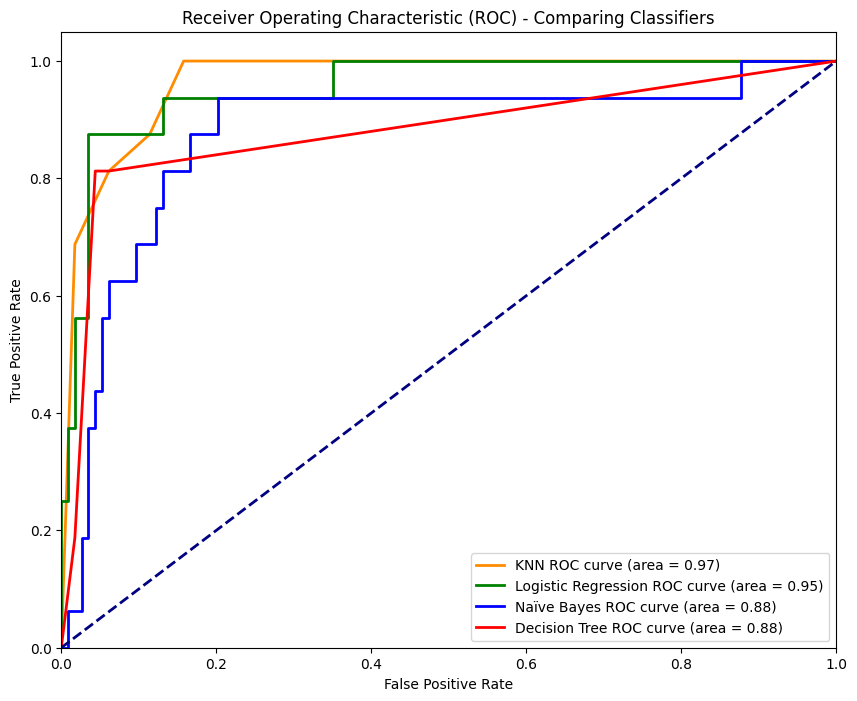

In [41]:
# Plot ROC Curves for multiple classifiers on the same plot
plt.figure(figsize=(10, 8))

# KNN ROC curve
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label=f'KNN ROC curve (area = {roc_auc_knn:.2f})')

# Logistic Regression ROC curve
plt.plot(fpr_logistic, tpr_logistic, color='green', lw=2, label=f'Logistic Regression ROC curve (area = {roc_auc_test_logistic:.2f})')

# Naïve Bayes ROC curve
plt.plot(fpr_nb, tpr_nb, color='blue', lw=2, label=f'Naïve Bayes ROC curve (area = {roc_auc_test_nb:.2f})')

# Naïve Bayes ROC curve
plt.plot(fpr_dt, tpr_dt, color='red', lw=2, label=f'Decision Tree ROC curve (area = {roc_auc_test_dt:.2f})')

# Adding a diagonal line representing random guesses (no discrimination)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Configure the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Comparing Classifiers')

# Add a legend
plt.legend(loc="lower right")

# Show the plot
plt.show()
